## Introduction

In today's market, many companies have a mobile presence. Often, these companies provide free products/services in their mobile apps in an attempt to transition their customers to a paid membership. Some examples of paid products, which originate from free ones are YouTube Red, Pandora Premium, Audible Subscription and You Need a Budget. Since marketting efforts are never free, these companies need to know exactly who to target with offers and promotions.

1.  Market: The target audience is customers who use a company's free product. In this notebook, we will refer this to the users who installed (and used) the company's free mobile app.

2. Product: The paid memberships often provide enhanced versions of the free products already given for free, alongside new features. For example, YouTube Red allows you to leave the app while still listening to a vide

3. Goal: The objective of this model is to predict which users will not subscribe to the paid membership, so that greater marketing efforts can go into trying to "convert" them to paid users


### Business Challenge

In this notebook, we will help a fintech company that wants to provide its customers with a paid mobile app subscription that will allow them to track all of their finances in one place. To attrach customers, the company releases a free version of their app with some of the main features unlocked.

### Objective

We will identify which users will most likely **NOT** enroll in the paid product, so that additional offers can be given to them. Because of the costs of these offers, the company does not want to offer them to everybody, especially customers who were going to enroll anyways

### Data

We will use customers' app behavior data. This allows us to see the date and time of app installation, as well as the features the users engaged with within the app. App behavior is characterized as the list of app screens the user looked at, and whether the user played the financial mini-games available. 

The app usage data is only from the user's first day in the app. This limitation exists because users can enjoy a 24-hour free trial of the premium features, and the company wants to target them with new offers shortly after the trial is over


### Process


The model building process is composed of multiple parts. Some of the things we will cover include:

**Plotting:** with matplotlib and seaborn for Exploratory Data Analysis (EDA)

**Data Manipulation:** with pandas and numpy for all of our data formatting steps

**Classification models:** from sklearn library (logistic regression and Regularization)

**Tuning:** K-Fold cross Validation, Grid Search (Parameter Tuning) and Feature Selection algorithms


1. user: numerical ID of the user
2. first_open:date and time user first opened the app
3. dayofweek: Day of the week in numerical form (0=Sunday or 6 = Saturday)
4. hour: Hour of the day when user first opened the app
5. age: Age of the user
6. screen_list: Every single screen name user has visited in first 24 hours
7. numscreens: Number of screens that appear in screen_list
8. minigame: App has a mini game, if users played mini game with 24 hours they have'1' if not '0'
9. liked: if user has liked any feature thus value is set as '1', if not '0'
10. user_premium_feature: If the user used premium feature
11. enrolled: Response variable if user enrolled to the premium 
12. enrolled_date: enrolled date for the users who enrolled (could be after first 24 hours)


In [127]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [128]:
dataset = pd.read_csv('appdata10.csv')

In [129]:
dataset.head(10) # Viewing the Data
dataset.describe() # Distribution of Numerical Variables

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


### Data Cleaning

In [130]:
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

In [131]:
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])

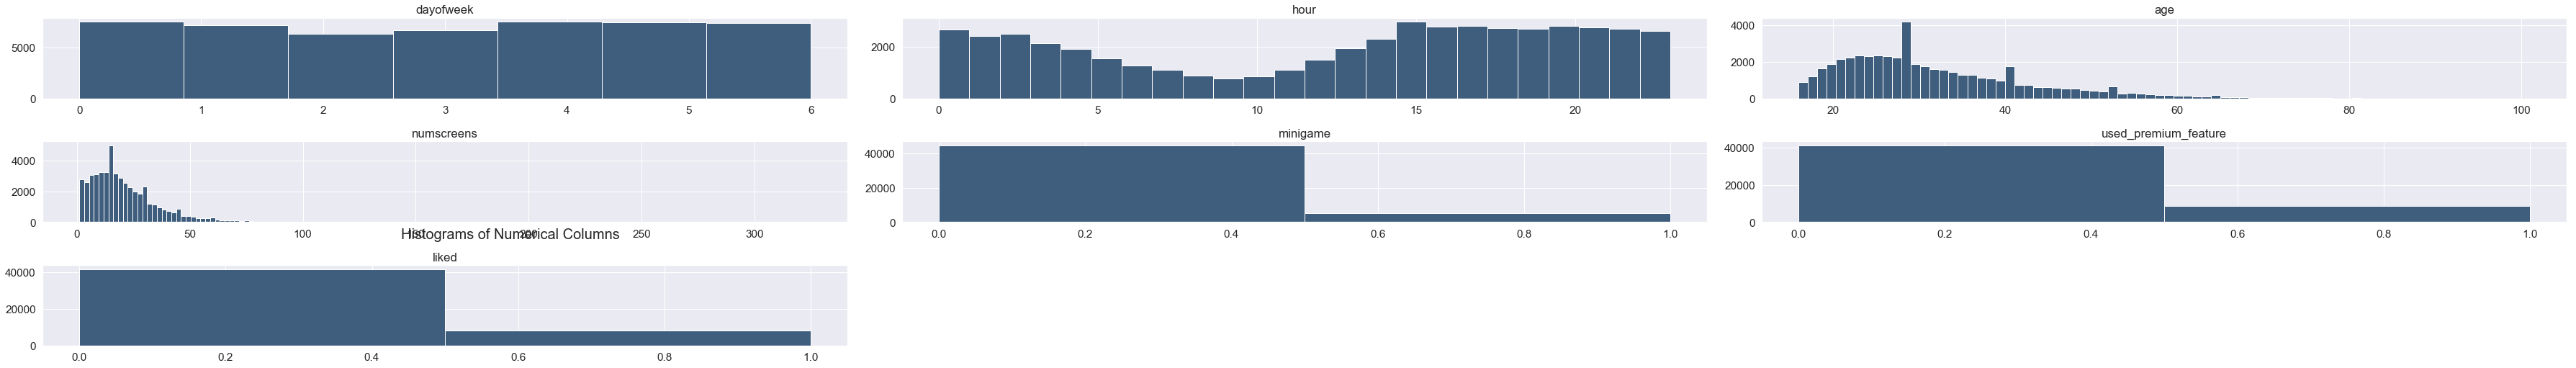

In [132]:
# Histograms

plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
    #plt.tight_layout(rect=[0, 0.003, 1, 0.95])
    plt.tight_layout(rect=[0, 0.03, 2.5, 2.5])

Few things to observe:


* Hour has a big dip at 10, its UTC hours. If we translate it to EST, its very late at night, so it makes sense
* Age is even distribution apart from few jumps

numscreens has even distribution too, except for few outliers

### Co-relation

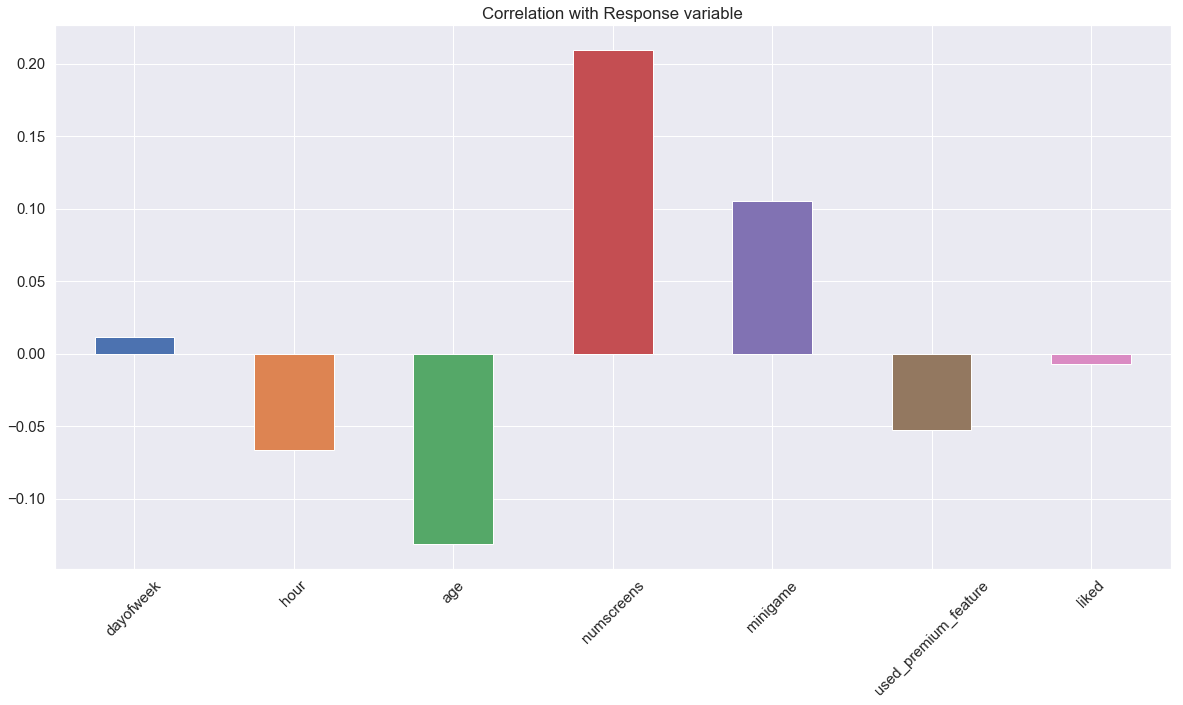

In [133]:
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Response variable',
                  fontsize = 15, rot = 45,
                  grid = True)

Few things to note: 

 day of week not related
 
 Hour  - earlier the hour, less likely to be related
 Age = older the person, less likely. In other words, younger people more likely to enrol...which makes sense
 numscreen - possibly co-related with response variable
 minigame - if user is engaged, more likely to enrol
used_premium_feature - Interestingly, used premium featuee is negatively co-related. User is less likely
liked - not related

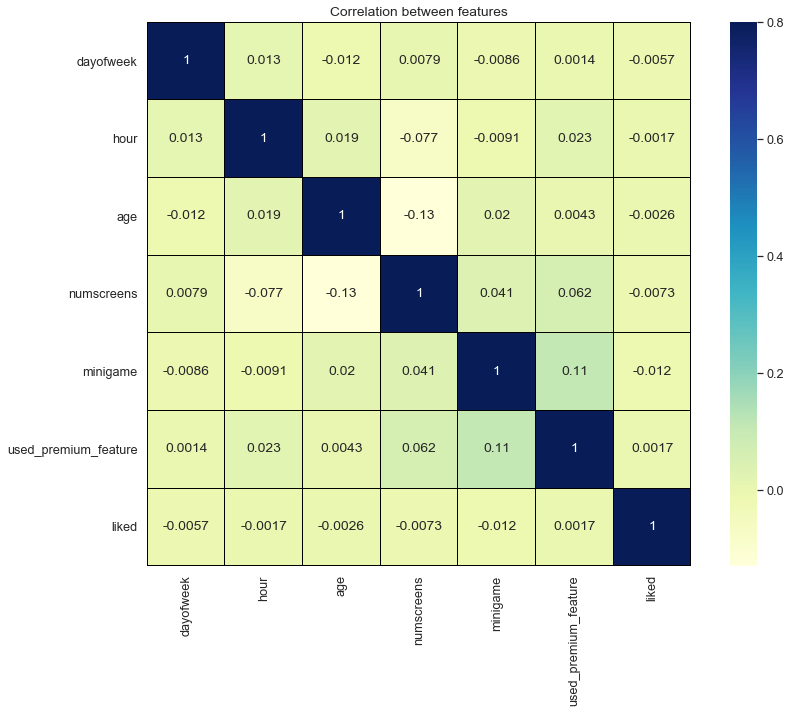

In [134]:
#Correlation matrix  Similar but between each individual field. 

corr=dataset2.corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="black")
plt.title('Correlation between features');


#Conclusion

Age vs numscreens - negatively correlated. Younger people more involved
Numofscreens vs used_premium feature - makes sense that they corelated
mini game vs used_premium_feature 

In [135]:
# Formatting Date Columns
dataset.dtypes #most are int , few are objects. We will convert it
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

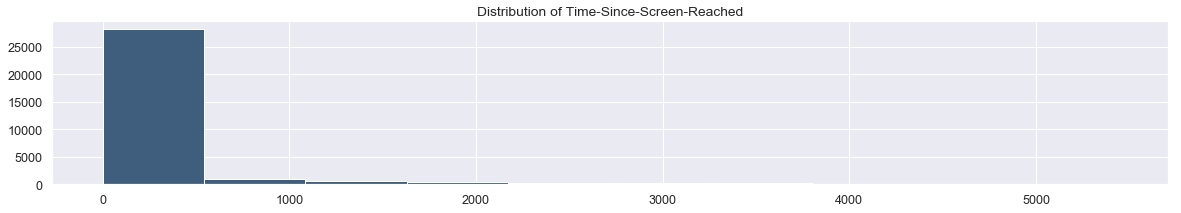

In [136]:
# Selecting Time For Response
#those two are converted

#create new column

dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
#fig = plt.figure(figsize=(28, 28))
plt.show()


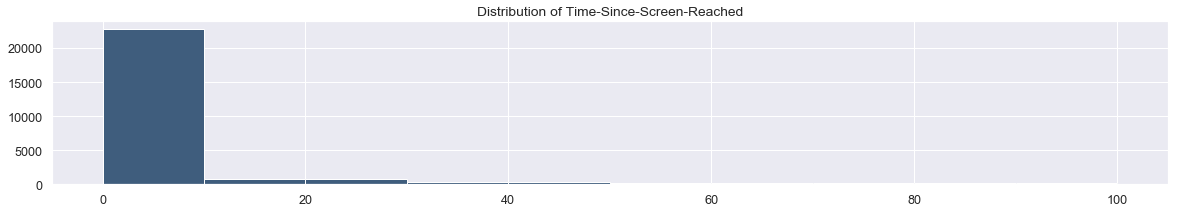

In [137]:
plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100]) #plotting to check best hour
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

In [138]:
# we notice the difference distribution tells us most enrollment in first 10 hours. Some in 20 and 30.
# We will restrict ourself to first 2 days (48 hours)

dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])  #dropping columns we dont need

In [139]:
# Load Top Screens
# Feature engineering to Screens (which screen was visited) - to convert screens so that model can read it
# Information we got from analyst for top screens users use: 
top_screens = pd.read_csv('top_screens.csv').top_screens.values
top_screens


array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [140]:
# will create columns for popular screens and for rest another column?
# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ','



In [141]:
# Create another column "other" to get value: how many left over screens we have

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list']) #drop column

In [142]:
# Funnels : group of screens that belong to same set, co-related screens...to keep co-relation we will move them to one funnel

# we know which screen belong to which in this product


savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1) #creating new column, count of saving screens, counts all columns
dataset = dataset.drop(columns=savings_screens)


In [143]:


cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)


In [144]:
cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

In [145]:
loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

In [146]:
#save this new dataset

#dataset.to_csv("new_appdata.csv", index = False)

In [147]:
# Data pre-processing

import time

In [148]:
# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

In [149]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [150]:
# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])


In [151]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2


In [152]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1')
classifier.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [153]:

# Predicting Test Set
y_pred = classifier.predict(X_test)

In [154]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)


0.7659703300030276

Test Data Accuracy: 0.7681


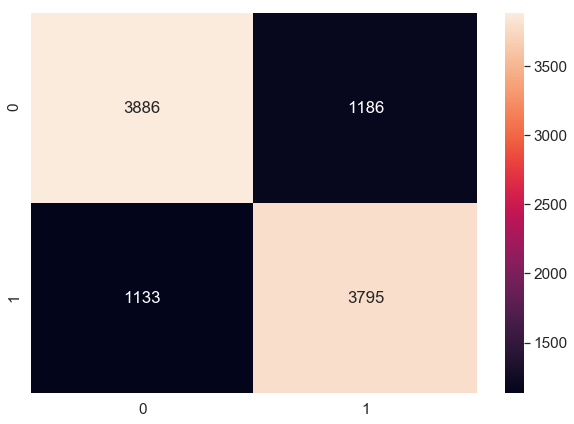

In [155]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [156]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.767 (+/- 0.010)


In [157]:

# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,dayofweek,0.032574
1,hour,-0.003600
2,age,-0.149688
3,numscreens,-0.130597
4,minigame,-0.026462
5,used_premium_feature,-0.065907
6,liked,0.010695
7,location,-0.028331
8,Institutions,-0.062195
9,VerifyPhone,0.650341


In [158]:
#### Model Tuning ####

## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV


In [159]:
# Select Regularization Method
penalty = ['l1', 'l2']


In [160]:
# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [ ]:
# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters


In [ ]:

## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

In [ ]:
# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

In [ ]:
# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_


In [ ]:
#### End of Model ####


# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [ ]:
final_results